In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from data.data_processing import ProcessInput
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Modelling Premier League results

Attempt to build a model to predict the result of a PL team's upcoming games

### Load fixture history data

Sources:

- Fixture history for PL teams since 1990 scraped from World Football: http://www.worldfootball.net/teams.
- Stadium locations from Google Maps' API: https://maps.googleapis.com/maps/api/geocode

Currently only interested in the Premier League, so limit the data to that for now

In [2]:
file_path = os.path.join('data', 'training_data', 'world_football_fixture_history.csv')
df = pd.read_csv(file_path)
df = df[df['competition'].str.contains('Premier League')]
df.head(5)

,round,date,opponent,result,competition,season,season_number,team,round_number,team_score,opposition_score,team_ht_score,opposition_ht_score,team_at_home,team_win,team_draw,team_loss
0,1. Round,1989-08-18,Manchester City,3:1 (1:1),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,1.0,3,1,1,1,1,True,False,False
1,2. Round,1989-08-22,Aston Villa,1:1 (1:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,2.0,1,1,1,0,0,False,True,False
2,3. Round,1989-08-25,Luton Town,0:0 (0:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,3.0,0,0,0,0,0,False,True,False
3,5. Round,1989-09-08,Derby County,3:0 (0:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,4.0,3,0,0,0,0,True,False,False
4,4. Round,1989-09-11,Crystal Palace,9:0 (3:0),Premier League 1989/1990,1989 / 1990,0,liverpool-fc,5.0,9,0,3,0,1,True,False,False


## Feature extraction

Use predefined transformation method to add in additional features including:

- A scaled version of the date to act as a weight column, giving more weight to more recent games
- Extracting the day of week from the data column, as well as days since last game
- Home/away flag
- Add the current win streak and undefeated streaks as integers
- Add form data for the team of interest and their opposition (# wins in last 5 - # losses)
- Some metrics such as points per game this season (PPG)
- Create a beatability index for each oppositon based on previous performance against them

In [3]:
processor = ProcessInput()
df = processor.fit_transform(df)
df.head()

,date,opponent,result,competition,season,season_number,team,round_number,team_score,opposition_score,...,PPG,season_points,GFPG,GAPG,GDPG,recent_form,season_points_opponent,PPG_opponent,GDPG_opponent,recent_form_opponent
0,1.0,30,3,Premier League 2017/2018,2017 / 2018,28,chelsea-fc,38.0,0,0,...,1.631579,62.0,1.315789,0.657895,0.657895,0.0,38.0,1.000000,-0.289474,0.0
1,1.0,46,3,Premier League 2017/2018,2017 / 2018,28,manchester-united,38.0,0,0,...,1.789474,68.0,1.394737,0.526316,0.868421,0.0,42.0,1.105263,-0.236842,0.0
2,1.0,48,3,Premier League 2017/2018,2017 / 2018,28,everton-fc,38.0,0,0,...,1.131579,43.0,0.842105,1.236842,-0.394737,0.0,39.0,1.026316,-0.394737,0.0
3,1.0,0,3,Premier League 2017/2018,2017 / 2018,28,burnley-fc,38.0,0,0,...,1.210526,46.0,0.578947,0.657895,-0.078947,0.0,41.0,1.078947,-0.263158,0.0
4,1.0,26,3,Premier League 2017/2018,2017 / 2018,28,southampton-fc,38.0,0,0,...,0.947368,36.0,0.763158,1.078947,-0.315789,0.0,82.0,2.157895,1.552632,0.0


### Choose a team to model

Data is available for most PL teams but at the moment feels best to model one at a time

In [6]:
team = 'liverpool-fc'
df = df[df['team'].str.contains(team)]
df.drop(['team'], inplace=True, axis=1)

# Also separate future fixtures
future_df = df[df['result'] == 3]
df = df[df['result'] != 3]



### Average performance vs specific opposition

A beatability index gives an indication of how the teaam plays against each team in the premier league.

For any given opposition, it is simply:

\begin{align}
b_{opp} = \frac{games\ won_{opp}}{total\ games_{opp}} - \frac{games\ lost_{opp}}{total\ games_{opp}}
\end{align}



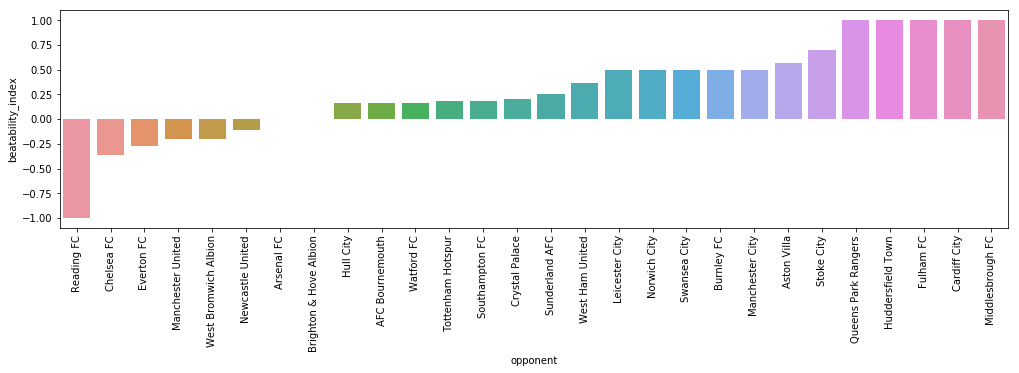

In [7]:
plt.figure(figsize=[17, 4])
beatability_df = processor.beatability_df[processor.beatability_df['team'] == team]
barplot = sns.barplot(x='opponent', 
                      y='beatability_index', 
                      data=beatability_df.sort_values(by='beatability_index'))
for label in barplot.get_xticklabels():
    label.set_rotation(90)

### Performance as season progresses

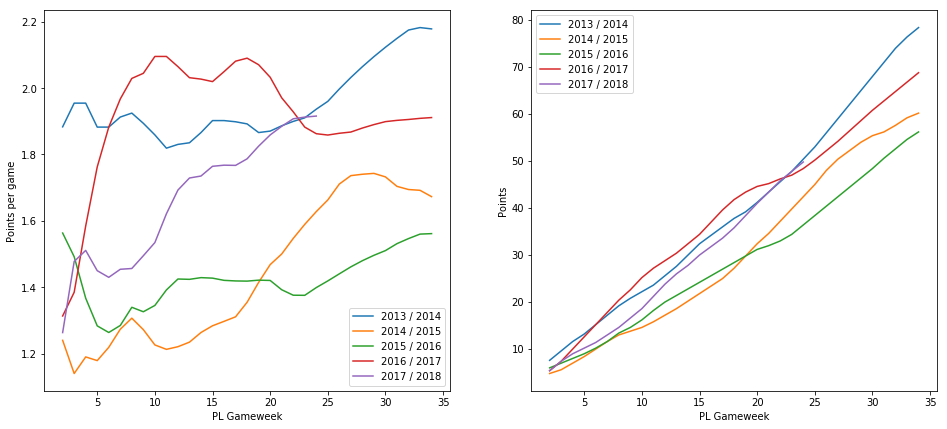

In [8]:
seasons_to_plot = 5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,7])

for season in range(df['season_number'].max()+1 - seasons_to_plot, df['season_number'].max()+1):
    season_df = df[df['season_number'] == season]
    season_years = season_df['season'].mode().values[0]
    axs[0].plot(season_df['round_number'], season_df['PPG'].rolling(5).mean(), label=season_years)
    axs[1].plot(season_df['round_number'], season_df['season_points'].rolling(5).mean(), label=season_years)
    
axs[0].set_ylabel('Points per game')    
axs[1].set_ylabel('Points') 
for ax in axs:
    ax.legend()
    ax.set_xlabel('PL Gameweek')

plt.show()

### Correlation of features with label

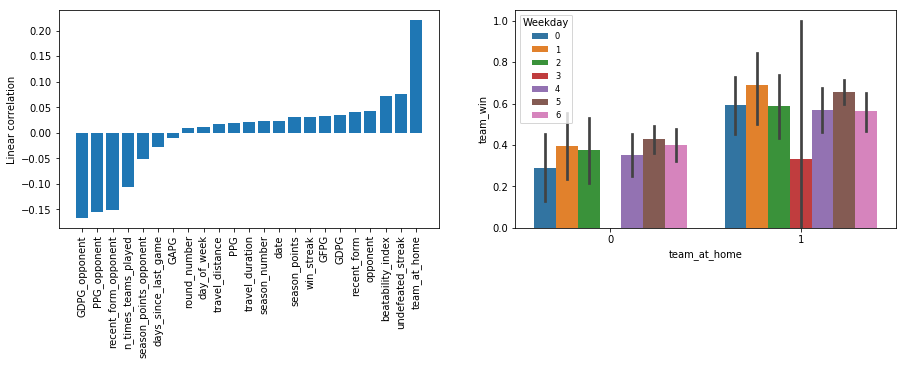

In [9]:
# Calculate correlation matrix then extract the correlations with respect to the win flag
corr_mat = df.corr()
correlation_with_win = corr_mat['team_win']
correlation_with_win = correlation_with_win[~np.isin(correlation_with_win.index.values, 
                                                     ['team_win', 'result', 'team_loss', 'team_draw',
                                                     'team_score', 'opposition_score'])]
correlation_with_win.sort_values(inplace=True)

# Plot these correlations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,4])
ax[0].bar(np.arange(len(correlation_with_win)), correlation_with_win)
ax[0].set_xticks(np.arange(len(correlation_with_win)))
ax[0].set_xticklabels(correlation_with_win.index.values, rotation=90)
ax[0].set_ylabel('Linear correlation')

# Plot a bar chart to see how home advantage and day of week affect the win rate
sns.barplot(data=df, x='team_at_home', y='team_win', hue='day_of_week', ax=ax[1])
ax[1].legend(loc=2, title='Weekday', fontsize='small')
plt.show()

So home advantage has the strongest linear relationship by a way, and appears to be most important on Fridays! Perhaps more interesting is that it matters more on Saturday (`weekday = 5`) than Sunday (`weekday = 6`)

### Effect of win/undefeated streaks

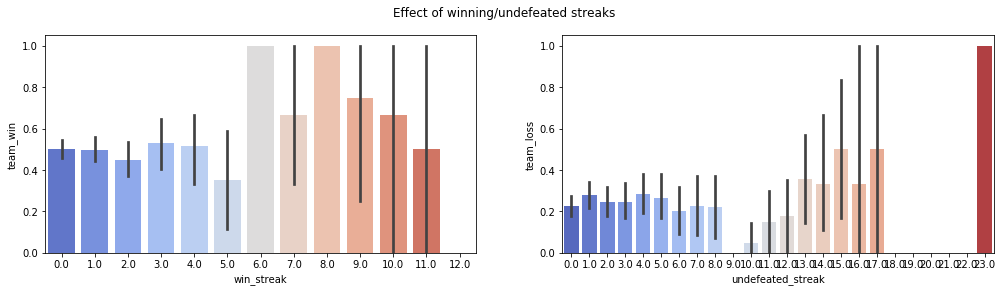

In [10]:
# Plot the streaks
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[17,4])
sns.barplot(data=df, x='win_streak', y='team_win', ax=ax[0], palette='coolwarm')
# plt.scatter()
sns.barplot(data=df, x='undefeated_streak', y='team_loss', ax=ax[1], palette='coolwarm')
plt.suptitle('Effect of winning/undefeated streaks')
plt.show()

### Drop data that we can't use in training

In [11]:
# E.g. goals scored and win flags used in the visualisations
df = processor.drop_features(df)
future_df = processor.drop_features(future_df)

## Dimensionality reduction

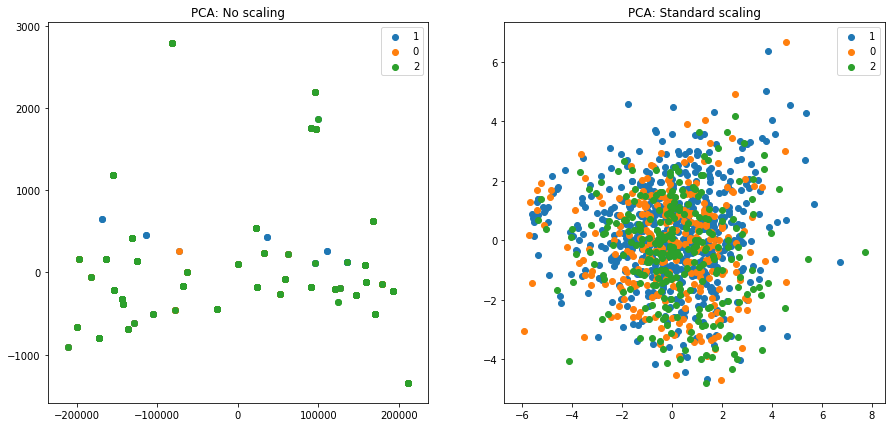

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA without scaling
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.fillna(0))

# PCA with scaled variables
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))
pca_sc = PCA(n_components=2)
scaled_pca = pca_sc.fit_transform(scaled_df)

# Plot the new datasets, colouring by result
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=[15,7])

for result in df['result'].unique():
    result_mask = df['result'] == result
    ax0.scatter(X_pca[result_mask, 0], X_pca[result_mask, 1], label=result)
    
for result in df['result'].unique():
    result_mask = df['result'] == result
    ax1.scatter(scaled_pca[result_mask, 0], scaled_pca[result_mask, 1], label=result)
   
ax0.legend()
ax0.set_title('PCA: No scaling')
ax1.legend()
ax1.set_title('PCA: Standard scaling')

plt.show()

So it looks like with the current features it is difficult to separate results linearly.

### Create a stratified test set

Stratify by fixture result to maintain equal distributions of wins, draws & losses.

In [13]:
train, test, y_train, y_test, train_weight = processor.stratified_train_test(df)

### Build a model

In [14]:
# Add a class weight to the current date weight
# class_weights = {0: sum(y_train == 0)/len(y_train), 
#                  1: sum(y_train == 1)/len(y_train), 
#                  2: sum(y_train == 2)/len(y_train)}
# for class_ in np.unique(y_train):
#     train_weight[y_train == class_] = train_weight[y_train == class_] / class_weights[class_]

In [15]:
import lightgbm as lgbm

# Create a training set
categoricals = ['opponent', 'team_at_home', 'day_of_week']
lgbm_train_set = lgbm.Dataset(data=train, label=y_train, 
                              categorical_feature=categoricals, 
                              weight=train_weight,
                              free_raw_data=False)

# Set the training parameters
lgbm_params = {'application': 'multiclass',
               'booting': 'gbdt',
               'metric': 'multi_logloss',
               'training_metric': True,
               'learning_rate': 0.05,
               'feature_fraction': 0.8,
               'min_data_in_leaf': 30,
               'num_leaves': 31,
               'num_classes': 3}

In [16]:
cv = True
if cv:
    cv_results = lgbm.cv(train_set=lgbm_train_set, 
                         params=lgbm_params, 
                         nfold=5, 
                         verbose_eval=0, 
                         num_boost_round=100,
                         early_stopping_rounds=10)
    best_iteration = len(cv_results['multi_logloss-mean'])
    print('Number of boosting rounds = {:d}'.format(best_iteration))
    print('Mean log loss from best boosting round = {:.4f}'.format(cv_results['multi_logloss-mean'][-1]))

Number of boosting rounds = 29
Mean log loss from best boosting round = 1.0161


In [17]:
clf = lgbm.train(train_set=lgbm_train_set, 
                 params=lgbm_params,
                 num_boost_round=best_iteration)

In [18]:
y_prob = clf.predict(test, num_iteration=best_iteration)
y_pred = y_prob.argmax(axis=1)

LGBM classification accuracy =  	 51.35%


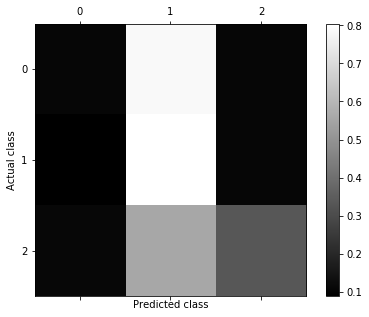

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# Simple accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
print("LGBM classification accuracy =  \t {:.2f}%".format(100*accuracy))

# Visualise the confusion matrix, normalised for classification frequency
conf_matrix = confusion_matrix(y_test, y_pred)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
# np.fill_diagonal(norm_conf_matrix, 0)

fig, ax = plt.subplots(figsize=[7,5])
conf_plot = ax.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.colorbar(ax=ax, mappable=conf_plot)
plt.show()

In [20]:
print(precision)
print(recall)

[ 0.27272727  0.54878049  0.5       ]
[ 0.10714286  0.80357143  0.33333333]


In [21]:
print(np.histogram(y_pred, bins=[0, 1, 2, 3]))
print(np.histogram(y_test, bins=[0, 1, 2, 3]))

(array([11, 82, 18], dtype=int64), array([0, 1, 2, 3]))
(array([28, 56, 27], dtype=int64), array([0, 1, 2, 3]))


Lighter colors represent larger numbers in that position, so in this case we can see a lot of the errors are coming from draws (actual = 0) predicted to be wins (prediction = 1) in the centre-top position.

Second worst are losses predicted to be wins. This strongly indicates that winning predictions are the most wrong.

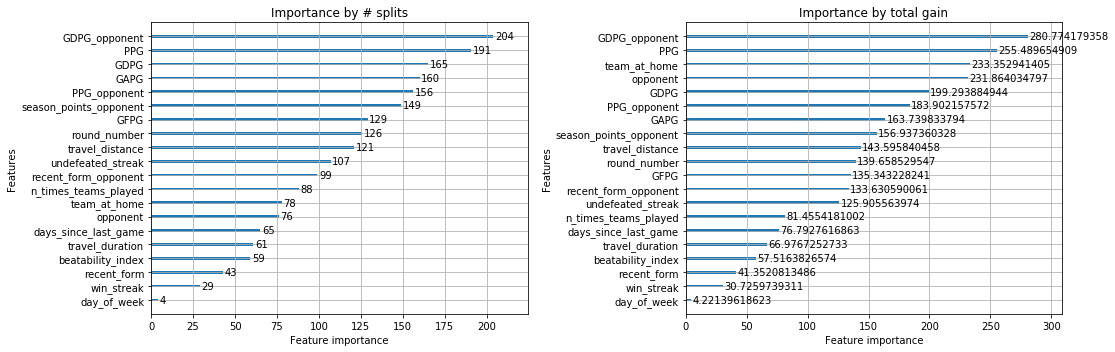

In [22]:
# Save model
clf.save_model(filename=os.path.join('models', 'lgbm_result_classifier.txt'))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 5])
lgbm.plot_importance(clf, ax=ax, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, importance_type='gain')

ax.set_title('Importance by # splits')
ax1.set_title('Importance by total gain')

plt.tight_layout()
plt.show()

### Predict remaining PL games

In [23]:
# Next game features
future_df.sort_values(by='date', ascending=True, inplace=True)
future_dates = future_df.pop('date')
future_df.reset_index(drop=True, inplace=True)

Make prediction for each future row

In [24]:
future_predictions, future_probs = [], []
for i in range(len(future_df)):
    y_prob_f = clf.predict(future_df.loc[i, :])
    y_pred_f = y_prob_f.argmax(axis=1)
    future_predictions.append(y_pred_f)
    future_probs.append(y_prob_f)
    
    # Amend 'future' entries of the df with the predicted result
    if i < len(future_df) - 1:
        
        # If they win...
        if y_pred_f == 1:
            
            future_df.loc[i + 1, 'win_streak'] = future_df.loc[i, 'win_streak'] + 1
            future_df.loc[i + 1, 'undefeated_streak'] = future_df.loc[i, 'undefeated_streak'] + 1
            
            future_df.loc[i + 1, 'PPG'] = (future_df.loc[i, 'round_number'] * future_df.loc[i, 'PPG'] + 3) / \
                                           (future_df.loc[i, 'round_number'] + 1)
            
        # Draw...
        elif y_pred_f == 0:
            future_df.loc[i + 1, 'win_streak'] = 0
            future_df.loc[i + 1, 'undefeated_streak'] = future_df.loc[i, 'undefeated_streak'] + 1
            
            future_df.loc[i + 1, 'PPG'] = (future_df.loc[i, 'round_number'] * future_df.loc[i, 'PPG'] + 1) / \
                                           (future_df.loc[i, 'round_number'] + 1)
            
        # Lose...
        else:
            future_df.loc[i + 1, 'win_streak'] = 0
            future_df.loc[i + 1, 'undefeated_streak'] = 0   
            future_df.loc[i + 1, 'PPG'] = future_df.loc[i, 'round_number'] / (future_df.loc[i, 'round_number'] + 1) 

Output predictions as markdown to go into the wiki

In [25]:
print('| Date: Opposition | Win | Draw | Loss | | | |')
for i in range(len(future_df)):
    if future_df.loc[i, 'team_at_home']:
        home_flag = 'H'
    else:
        home_flag = 'A'
    print('| {:.4f}: {} ({})| {:.2f} | {:.2f} | {:.2f} |  |  |  | '\
          .format(future_dates.iloc[i], 
                  processor.opponent_encoder.inverse_transform(future_df.loc[i, 'opponent']), 
                  home_flag, 
                  100*future_probs[i][0][1], 
                  100*future_probs[i][0][0], 
                  100*future_probs[i][0][2]))

| Date: Opposition | Win | Draw | Loss | | | |
| 0.9933: Newcastle United (H)| 43.47 | 32.41 | 24.13 |  |  |  | 
| 0.9940: Manchester United (A)| 21.06 | 37.84 | 41.09 |  |  |  | 
| 0.9947: Watford FC (H)| 40.14 | 23.04 | 36.82 |  |  |  | 
| 0.9960: Crystal Palace (A)| 46.02 | 25.59 | 28.39 |  |  |  | 
| 0.9966: Everton FC (A)| 42.09 | 23.25 | 34.67 |  |  |  | 
| 0.9972: AFC Bournemouth (H)| 42.94 | 33.53 | 23.53 |  |  |  | 
| 0.9979: West Bromwich Albion (A)| 47.52 | 26.45 | 26.02 |  |  |  | 
| 0.9986: Stoke City (H)| 42.05 | 31.98 | 25.97 |  |  |  | 
| 0.9992: Chelsea FC (A)| 19.90 | 33.26 | 46.85 |  |  |  | 
| 1.0000: Brighton & Hove Albion (H)| 64.28 | 20.14 | 15.58 |  |  |  | 


Feature contribution of next match

In [26]:
# feature_contributions = clf.predict(future_df.loc[0, :], pred_contrib=True)
# ind = np.arange(len(clf.feature_importance()))

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
# ax[0].bar(ind, clf.feature_importance())
# ax[1].bar(ind, feature_contributions.ravel()[:-1])
# for axs in ax:
#     axs.set_xticks(np.arange(len(clf.feature_importance())))
#     axs.set_xticklabels(clf.feature_name(), rotation=90)
# plt.show()

In [27]:
# Calculate log loss of prediction given actual result
from sklearn.metrics import log_loss

y_actual_live = np.array([[1, 0, 0]])
y_prob_live = np.array([[.3899, .3567, .2534]])
log_loss(y_actual_live, y_prob_live)

0.94186498299358534